# Applied Data Science Capstone Project

## Best place to open an Indian Restaurant in the city of Toronto,Canada

### Business Problem: To identify the best location to open an Indian Restaurant in the city of Toronto

## Introduction: 

Indian immigrants have been a part of life in Canada for over a century. As of 2020, there are more than one million Indian citizens in Canada.

Toronto is a major magnet for Indian immigrants. The city is Canada’s economic engine and is also home to some of the continent’s top schools and universities. Opening an Indian restaurant in this city should be an exciting idea for business startup.

In this Project, We will identify the best location to setup an Indian restaurant by analyzing the neighborhoods of Toronto and finding out the borough that has the least number of Indian restaurants. As lesser number implies little competition for the startup.

## Data Acquisition

#### Firstly the data related to different locations(postal codes) of the city,Toronto is acquired from wikipedia page
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

#### The geospatial coordinates (latitudes and longitudes)  of different locations are obtained from this .csv file
https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv

#### Four-Square location API has been used to explore and identify the top venues in the neighborhoods


## Webscraping and Data cleansing

First, We will scrape the wiki page to get the basic information of Toronto. In this table below, we can see that many postal codes are 'Not assigned' to any neighborhood.
As part of data pre-processing, we will go with few assumptions that helps in refining the data
1. we shall ignore these 'Not assigned' postal codes as these missing values may mislead the analysis.
2. We will combine the neighborhoods separated by a comma if there exists multiple neighborhoods for single postal code area. Example: M5A Regent Park,Harbourfront
3. If a cell has a borough but a Not assigned  neighborhood, then the neighborhood will be the same as the borough.

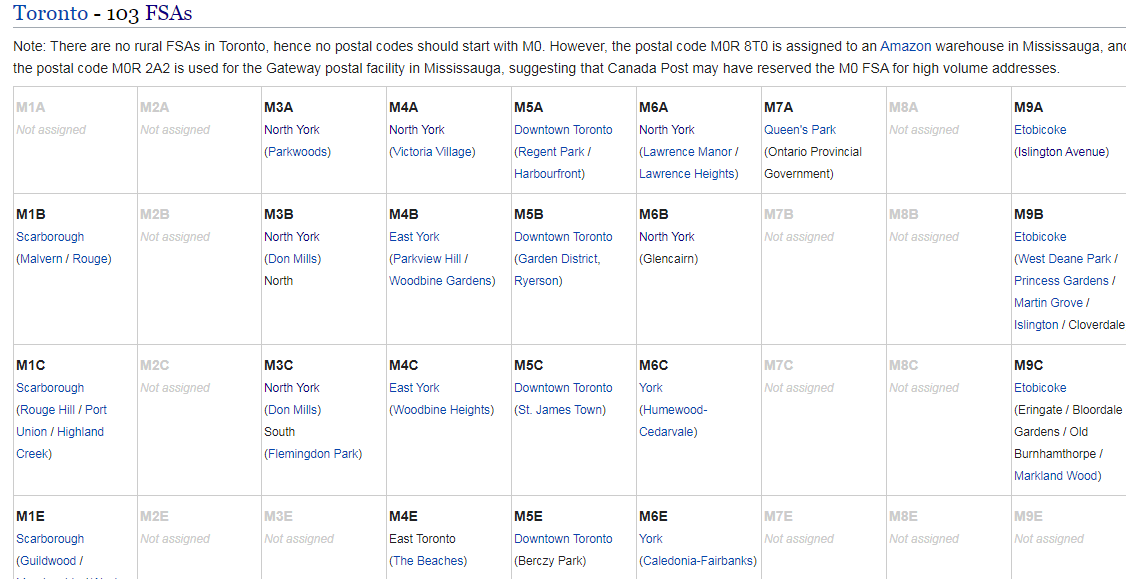

After data preprocessing, we will convert that data into Pandas dataframe for applying machine learning algorithms and for data visualisations.
We will get the output as below



![image](https://user-images.githubusercontent.com/81110444/118713850-14202200-b840-11eb-981e-5276140d74a4.png)

Then we will append the geospatial cooordinates.csv file to get the corresponding location coordinates (Latitude & longitude) of the postal codes. 
The output looks as below

![image](https://user-images.githubusercontent.com/81110444/118714660-43cf2a00-b840-11eb-9654-700782b8fc1e.png)

Now along with the above neighborhood data, we will leverage FourSquare API.
FourSquare API is used to explore these neighborhoods to fetch the details about different types of venues and their location.
This data will be used for our analysis and final result.
The sample data below:

![image](https://user-images.githubusercontent.com/81110444/118714824-7aa54000-b840-11eb-943c-baa52b70f6b9.png)

using Folium maps and K-means clustering we can identify clustered neighborhoods on maps  as below

![image](https://user-images.githubusercontent.com/81110444/118714956-a88a8480-b840-11eb-94cc-2c80abb8ba7f.png)

## Methodology

1. we will explore the neighborhoods of toronto city on maps
2. we will explore venues in those neighborhoods  
3. we will list out th venues of category 'restaurant'
4. We will list out the neighborhoods having Indian restaurant and their most common visited venues
5. Clustering

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
from bs4 import BeautifulSoup
import requests
from requests import get

### Scraping the webpage

In [4]:
url= 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html_content = requests.get(url).text
soup = BeautifulSoup(html_content, "lxml")

In [5]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

In [6]:
# print(table_contents)
df=pd.DataFrame(table_contents)

In [7]:
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [8]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [9]:
df.shape

(103, 3)

#### Appending location coordinates .csv

In [10]:
url= 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv'

In [11]:
!wget -q -O 'Geospatial_Coordinates.csv' url
print('Data downloaded!')

Data downloaded!


In [12]:
df2=pd.read_csv(url,sep=',')

In [13]:
df2.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [14]:
df1 = pd.merge(df, df2, left_on='PostalCode', right_on = 'Postal Code')
df1.drop('Postal Code', inplace=True, axis=1)

In [15]:
df1.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [16]:
df1.shape

(103, 5)

In [17]:
df1

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [18]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df1['Borough'].unique()),
        df1.shape[0]
    )
)

The dataframe has 15 boroughs and 103 neighborhoods.


In [19]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Solving environment: done

# All requested packages already installed.



In [20]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [21]:
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

Solving environment: done

# All requested packages already installed.



#### Map of Toronto city

In [22]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df1['Latitude'], df1['Longitude'], df1['Borough'], df1['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [23]:
CLIENT_ID = 'RCBY3O1XP3WGRNV13IKLS1PFRCORZI4IDWJIY1X3PKK00CX5' # your Foursquare ID
CLIENT_SECRET = 'EXKVP14LMIHYZQKAMAR10XFK4M2U5XOBCVE1VDFPQNMC3XPO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RCBY3O1XP3WGRNV13IKLS1PFRCORZI4IDWJIY1X3PKK00CX5
CLIENT_SECRET:EXKVP14LMIHYZQKAMAR10XFK4M2U5XOBCVE1VDFPQNMC3XPO


In [24]:
import json

In [25]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [26]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [27]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#### Let's explore the first neighborhood in our dataframe

In [28]:
df1.loc[0,'Neighborhood']

'Parkwoods'

In [29]:
neighborhood_latitude = df1.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df1.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df1.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


#### Now, let's get the top 100 venues that are in 'Parkwoods' within a radius of 500 meters

In [30]:
LIMIT = 100 # limit of number of venues returned by Foursquare API


radius = 500 # define radius


url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=RCBY3O1XP3WGRNV13IKLS1PFRCORZI4IDWJIY1X3PKK00CX5&client_secret=EXKVP14LMIHYZQKAMAR10XFK4M2U5XOBCVE1VDFPQNMC3XPO&v=20180605&ll=43.7532586,-79.3296565&radius=500&limit=100'

In [31]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60a80da43c68140820488999'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 3,
  'suggestedBounds': {'ne': {'lat': 43.757758604500005,
    'lng': -79.32343823984928},
   'sw': {'lat': 43.7487585955, 'lng': -79.33587476015072}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
       'name': 'Brookbanks Park',
       'location': {'address': 'Toronto',
        'lat': 43.751976046055574,
        'lng': -79.33214044722958,
        'labeledLatLngs': 

#### we know that all the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [32]:
!pip install -U numpy

!pip install -U pandas

!pip install -U scipy

!pip install -U scikit-learn

!pip install -U imbalanced-learn

In [33]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Now we are ready to clean the json and structure it into a pandas dataframe.

In [34]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,KFC,Fast Food Restaurant,43.754387,-79.333021
2,Variety Store,Food & Drink Shop,43.751974,-79.333114


In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### to run the above function on each neighborhood and create a new dataframe called Toronto_venues

In [36]:
Toronto_venues = getNearbyVenues(names=df1['Neighborhood'],
                                   latitudes=df1['Latitude'],
                                   longitudes=df1['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

#### Let's check the size of the resulting dataframe

In [37]:
print(Toronto_venues.shape)
Toronto_venues.head()

(2136, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


#### Let's check how many venues were returned for each neighborhood

In [38]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
Berczy Park,60,60,60,60,60,60
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16


#### Let's find out how many unique categories can be curated from all the returned venues

In [39]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 275 uniques categories.


Analyzing Each Neighborhood
We will anayze each Neighborhood with venues informations

In [40]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head(20)

,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### And let's examine the new dataframe size

In [41]:
Toronto_onehot.shape

(2136, 275)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [42]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000,

#### Let's confirm the new size

In [43]:
Toronto_grouped.shape

(99, 275)

#### Let's print each neighborhood along with the top 5 most common venues

In [44]:
num_top_venues = 5

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0  Latin American Restaurant   0.2
1                     Lounge   0.2
2             Breakfast Spot   0.2
3               Skating Rink   0.2
4             Clothing Store   0.2


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.25
1  Sandwich Place  0.12
2             Gym  0.12
3      Playground  0.12
4            Pool  0.12


----Bathurst Manor, Wilson Heights, Downsview North----
              venue  freq
0              Bank  0.10
1       Coffee Shop  0.10
2        Restaurant  0.05
3    Ice Cream Shop  0.05
4  Sushi Restaurant  0.05


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1                 Café  0.25
2   Chinese Restaurant  0.25
3                 Bank  0.25
4          Yoga Studio  0.00


----Bedford Park, Lawrence Manor East----
                     venue  freq
0              Coffee Shop  0.08
1               Restaurant  0.08
2           Sandwich Place  0.08
3    

#### Let's put that into a pandas dataframe

#### First, let's write a function to sort the venues in descending order

In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Now let's create the new dataframe and display the top 10 venues for each neighborhood

In [46]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Lounge,Breakfast Spot,Skating Rink,Clothing Store,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Gym,Playground,Pool,Coffee Shop,Pub,Yoga Studio,Mobile Phone Shop,Moroccan Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Restaurant,Ice Cream Shop,Sushi Restaurant,Fried Chicken Joint,Bridal Shop,Gas Station,Sandwich Place,Diner
3,Bayview Village,Japanese Restaurant,Café,Chinese Restaurant,Bank,Yoga Studio,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Comfort Food Restaurant,Indian Restaurant,Pizza Place,Pub,Café,Butcher


#### Let's find out which neighborhood has the first most common venue as Indian Restaurant

In [47]:
neighborhoods_venues_sorted_ind = neighborhoods_venues_sorted[neighborhoods_venues_sorted['1st Most Common Venue'].str.contains('Indian Restaurant')]
neighborhoods_venues_sorted_ind

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,"Dorset Park, Wexford Heights, Scarborough Town...",Indian Restaurant,Furniture / Home Store,Pet Store,Vietnamese Restaurant,Brewery,Chinese Restaurant,Modern European Restaurant,Motel,Moroccan Restaurant,Monument / Landmark
86,Thorncliffe Park,Indian Restaurant,Yoga Studio,Intersection,Pharmacy,Pizza Place,Coffee Shop,Discount Store,Restaurant,Sandwich Place,Middle Eastern Restaurant


Dorset Park, Wexford Heights, Scarborough Town... 

 #### Out of 2130 different venues lets find out the venues that are of category 'Restaurant'

In [48]:
Toronto_venues_restaurant = Toronto_venues[Toronto_venues['Venue Category'].str.contains('Restaurant')]

In [49]:
print(Toronto_venues_restaurant.shape)
Toronto_venues_restaurant.head()

(487, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
13,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
34,"Regent Park, Harbourfront",43.654260,-79.360636,El Catrin,43.650601,-79.358920,Mexican Restaurant
38,"Regent Park, Harbourfront",43.654260,-79.360636,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant


In [50]:
Toronto_venues_restaurant.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,1,1,1,1,1,1
"Bathurst Manor, Wilson Heights, Downsview North",3,3,3,3,3,3
Bayview Village,2,2,2,2,2,2
"Bedford Park, Lawrence Manor East",11,11,11,11,11,11
Berczy Park,12,12,12,12,12,12
"Brockton, Parkdale Village, Exhibition Place",2,2,2,2,2,2
Cedarbrae,3,3,3,3,3,3
Central Bay Street,17,17,17,17,17,17
Christie,2,2,2,2,2,2


In [51]:
print(Toronto_venues_restaurant.shape)

(487, 7)


#### Out of 2130 different venues, 483 venues are of 'Restaurant' category. Lets check the count of restaurants in the neighborhoods.


In [52]:
summary = Toronto_venues_restaurant.groupby(['Neighborhood']).count().reset_index()
summary['Count'] = summary['Venue']
summary = summary.drop(['Neighborhood Latitude', 'Neighborhood Longitude','Venue', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1)
summary = summary.sort_values('Count').reset_index(drop=True)
summary

,Neighborhood,Count
0,Agincourt,1
1,"West Deane Park, Princess Gardens, Martin Grov...",1
2,Victoria Village,1
3,"South Steeles, Silverstone, Humbergate, Jamest...",1
4,Parkwoods,1
5,"Northwood Park, York University",1
6,"Mimico NW, The Queensway West, South of Bloor,...",1
7,"Malvern, Rouge",1
8,"Lawrence Manor, Lawrence Heights",1
9,"Cliffside, Cliffcrest, Scarborough Village West",1


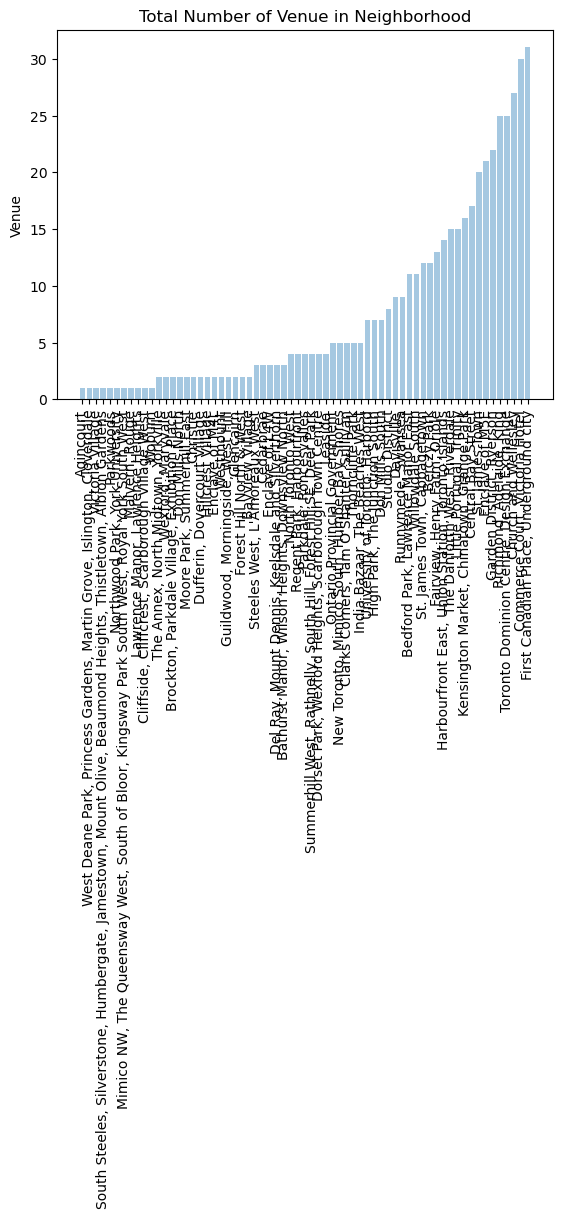

In [53]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = summary.Neighborhood
y_pos = np.arange(len(objects))
performance = summary.Count

plt.bar(y_pos, performance, align='center', alpha=0.4, width = 0.8)
plt.xticks(y_pos, objects)
plt.ylabel('Venue')
plt.title('Total Number of Venue in Neighborhood')
plt.xticks(rotation=90)

plt.show()

#### List of Neighborhoods having Indian Restaurants

In [54]:
Toronto_venues_restaurant_1 =Toronto_venues_restaurant.groupby(['Neighborhood','Venue Category']).count().reset_index()

In [55]:
print(Toronto_venues_restaurant_1.shape)
Toronto_venues_restaurant_1.head()

(341, 7)


,Neighborhood,Venue Category,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
0,Agincourt,Latin American Restaurant,1,1,1,1,1
1,"Bathurst Manor, Wilson Heights, Downsview North",Middle Eastern Restaurant,1,1,1,1,1
2,"Bathurst Manor, Wilson Heights, Downsview North",Restaurant,1,1,1,1,1
3,"Bathurst Manor, Wilson Heights, Downsview North",Sushi Restaurant,1,1,1,1,1
4,Bayview Village,Chinese Restaurant,1,1,1,1,1


In [56]:
Toronto_venues_restaurant_ind =Toronto_venues_restaurant_1[Toronto_venues_restaurant_1 ['Venue Category'].str.contains('Indian')]

print(Toronto_venues_restaurant_ind.shape)
Toronto_venues_restaurant_ind


(12, 7)


,Neighborhood,Venue Category,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
10,"Bedford Park, Lawrence Manor East",Indian Restaurant,1,1,1,1,1
19,Berczy Park,Indian Restaurant,1,1,1,1,1
32,Central Bay Street,Indian Restaurant,1,1,1,1,1
49,Church and Wellesley,Indian Restaurant,1,1,1,1,1
79,Davisville,Indian Restaurant,1,1,1,1,1
97,"Dorset Park, Wexford Heights, Scarborough Town...",Indian Restaurant,2,2,2,2,2
110,Enclave of M5E,Indian Restaurant,1,1,1,1,1
161,"Harbourfront East, Union Station, Toronto Islands",Indian Restaurant,1,1,1,1,1
274,"St. James Town, Cabbagetown",Indian Restaurant,1,1,1,1,1
294,"The Annex, North Midtown, Yorkville",Indian Restaurant,1,1,1,1,1


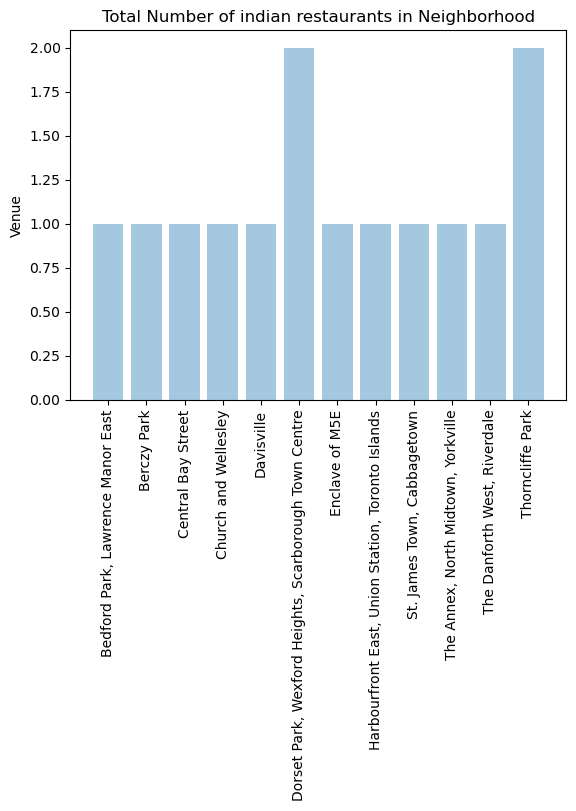

In [57]:
objects = Toronto_venues_restaurant_ind.Neighborhood
y_pos = np.arange(len(objects))
performance = Toronto_venues_restaurant_ind.Venue

plt.bar(y_pos, performance, align='center', alpha=0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Venue')
plt.title('Total Number of indian restaurants in Neighborhood')
plt.xticks(rotation=90)

plt.show()

#### Merging the dataframes to get the number of venues in the Neighborhoods having Indian Restaurants

In [58]:
result = pd.merge(Toronto_venues_restaurant_ind,
                 summary,
                 on='Neighborhood', 
                 how='left')

result =result.drop(['Venue Category','Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude'], axis=1)
result = result.sort_values('Count').reset_index(drop=True)

result 

,Neighborhood,Count
0,"The Annex, North Midtown, Yorkville",2
1,"Dorset Park, Wexford Heights, Scarborough Town...",4
2,Thorncliffe Park,5
3,Davisville,9
4,"Bedford Park, Lawrence Manor East",11
5,Berczy Park,12
6,"St. James Town, Cabbagetown",12
7,"Harbourfront East, Union Station, Toronto Islands",14
8,"The Danforth West, Riverdale",15
9,Central Bay Street,17


#### Bar chart for visualization

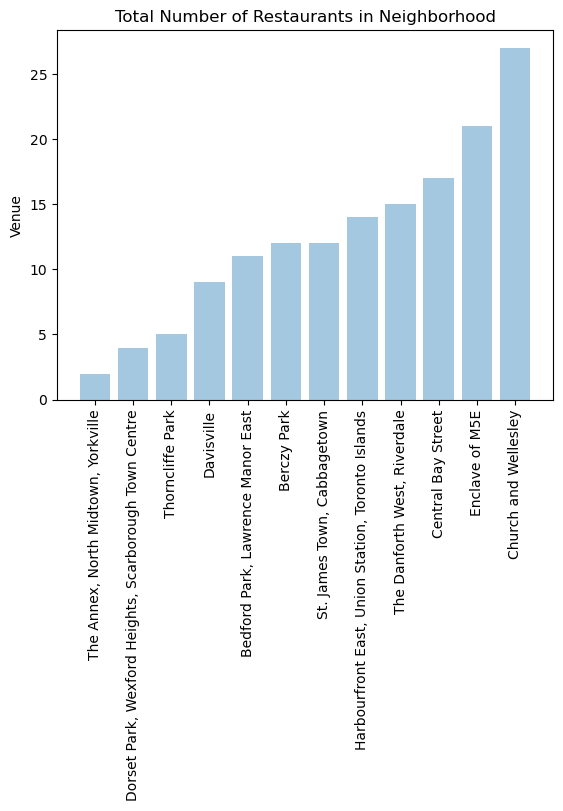

In [59]:
objects = result.Neighborhood
y_pos = np.arange(len(objects))
performance = result.Count

plt.bar(y_pos, performance, align='center', alpha=0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Venue')
plt.title('Total Number of Restaurants in Neighborhood')
plt.xticks(rotation=90)

plt.show()


## RESULTS

### We have got a total of 2130 venues  in the Toronto city for the given latitude and longitude coordinates within a radius of 500meters. There are 276 unique venue categories .
### Out of  these,  483 venues are related to restaurants and among those 483 venues only 13 venues are of ‘Indian Restaurant’.
### Lets plot the count of Indian restaurants in the neighborhoods containing those 13 venues.
### Lets also plot the total number of restaurants in those neighborhoods.



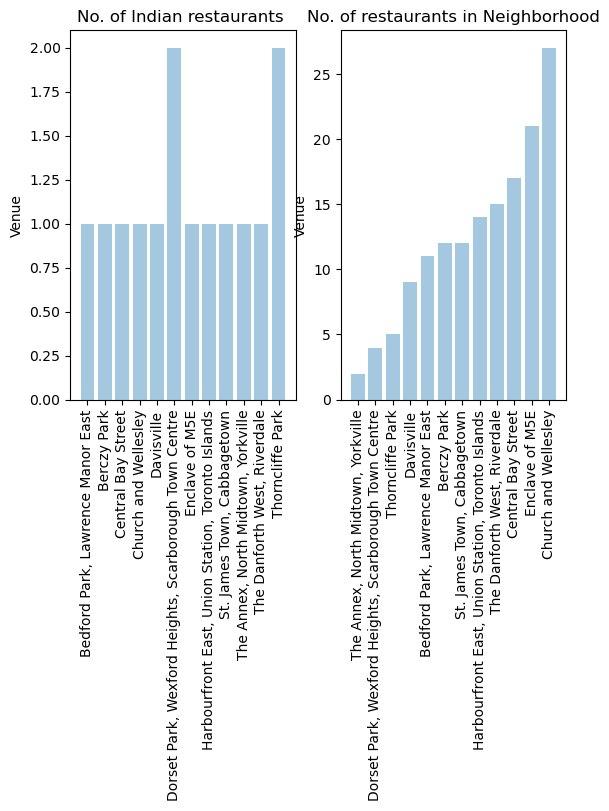

In [60]:
plt.subplot(1, 2, 1) # row 1, col 2 index 1
objects = Toronto_venues_restaurant_ind.Neighborhood
y_pos = np.arange(len(objects))
performance = Toronto_venues_restaurant_ind.Venue

plt.bar(y_pos, performance, align='center', alpha=0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Venue')
plt.title('No. of Indian restaurants ')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2) # index 2
objects_1 = result.Neighborhood
y_pos_1 = np.arange(len(objects))
performance_1 = result.Count

plt.bar(y_pos_1, performance_1, align='center', alpha=0.4)
plt.xticks(y_pos, objects_1)
plt.ylabel('Venue')
plt.title('No. of restaurants in Neighborhood')
plt.xticks(rotation=90)

plt.show()

### From the above bar graph we can observe that ‘ Dorset Park, Wexford Heights, Scarborough Town’and ‘ Thorncliffe Park’ has two Indian restaurants . These two neighborhoods also has 1st most common venue as 'Indian restaurant' but these two neighborhoods has a  total of 4 restaurants out of which 2 are Indian , so these two cannot be the best place to start the restaurant.

### The last 3 neighborhoods 'Central Bay Street','Enclave of M5E','Church and Wellesley' have a total of 16,21 and 28 restaurants respectively out of which 1 is an Indian restaurant. As these neighborhoods already have a lot of restaurants, these cannot be good place to start a new one.
 
## 'Davisville',  'Bedford Park, Lawrence Manor East',  'St. James Town, Cabbagetown'	
### has optimum number of restaurants with only 1 Indian restaurant.So these three neighborhoods could be the best places to start an Indian Restaurant

#### The top 10 most common venues in those neighborhoods

In [61]:
result_top_venues = pd.merge(Toronto_venues_restaurant_ind,neighborhoods_venues_sorted,on='Neighborhood',how='left')

In [62]:
result_top_venues

,Neighborhood,Venue Category,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bedford Park, Lawrence Manor East",Indian Restaurant,1,1,1,1,1,Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Comfort Food Restaurant,Indian Restaurant,Pizza Place,Pub,Café,Butcher
1,Berczy Park,Indian Restaurant,1,1,1,1,1,Coffee Shop,Cocktail Bar,Bakery,Seafood Restaurant,Restaurant,Beer Bar,Farmers Market,Pharmacy,Cheese Shop,Café
2,Central Bay Street,Indian Restaurant,1,1,1,1,1,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Bubble Tea Shop,Burger Joint,Japanese Restaurant,Salad Place,Pizza Place,Discount Store
3,Church and Wellesley,Indian Restaurant,1,1,1,1,1,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Gay Bar,Restaurant,Yoga Studio,Mediterranean Restaurant,Men's Store,Fast Food Restaurant,Dance Studio
4,Davisville,Indian Restaurant,1,1,1,1,1,Pizza Place,Sandwich Place,Dessert Shop,Café,Gym,Coffee Shop,Sushi Restaurant,Italian Restaurant,Park,Thai Restaurant
5,"Dorset Park, Wexford Heights, Scarborough Town...",Indian Restaurant,2,2,2,2,2,Indian Restaurant,Furniture / Home Store,Pet Store,Vietnamese Restaurant,Brewery,Chinese Restaurant,Modern European Restaurant,Motel,Moroccan Restaurant,Monument / Landmark
6,Enclave of M5E,Indian Restaurant,1,1,1,1,1,Coffee Shop,Seafood Restaurant,Cocktail Bar,Bakery,Italian Restaurant,Japanese Restaurant,Hotel,Restaurant,Beer Bar,Café
7,"Harbourfront East, Union Station, Toronto Islands",Indian Restaurant,1,1,1,1,1,Coffee Shop,Aquarium,Hotel,Café,Restaurant,Scenic Lookout,Fried Chicken Joint,Sporting Goods Shop,Brewery,Italian Restaurant
8,"St. James Town, Cabbagetown",Indian Restaurant,1,1,1,1,1,Restaurant,Park,Coffee Shop,Pub,Café,Pizza Place,Bakery,Italian Restaurant,Bar,General Entertainment
9,"The Annex, North Midtown, Yorkville",Indian Restaurant,1,1,1,1,1,Café,Sandwich Place,Coffee Shop,Pharmacy,Middle Eastern Restaurant,Pizza Place,Burger Joint,Flower Shop,Liquor Store,Donut Shop


## Cluster Neighborhoods

#### K-Means algorithm is one of the most common cluster method of unsupervised learning.Run k-means to cluster the neighborhood into 3 clusters.
I will use K-Means algorithm in this project.

I have analyzed the K-Means with elbow method and found the optimum k of the K-Means as 3 

In [63]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [64]:
# set number of clusters
kclusters = 3

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
# kmeans.labels_[0:10] 

labels = kmeans.labels_
labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2,
       0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0], dtype=int32)

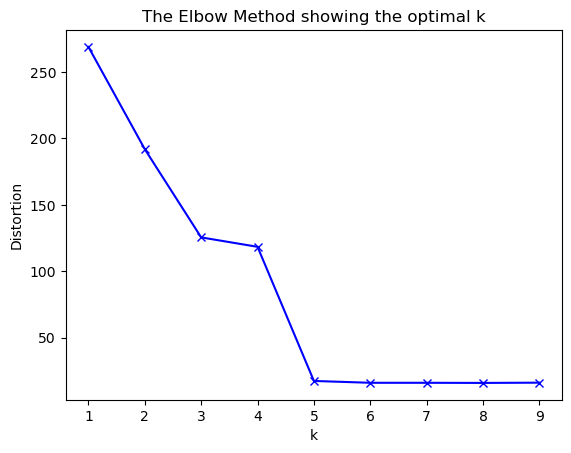

In [65]:
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(Toronto_grouped_clustering)
    #kmeanModel.fit(Toronto_grouped_clustering)
    distortions.append(sum(np.min(cdist(Toronto_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / Toronto_grouped_clustering.shape[0])

#There are different metric distance function for spatial distance. 
#I choose correlation instead of euclidean because the canberra function gives me more clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [66]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df1

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how = 'right')


# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_


toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
78,M1S,Scarborough,Agincourt,43.794200,-79.262029,Latin American Restaurant,Lounge,Breakfast Spot,Skating Rink,Clothing Store,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,2
93,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484,Pizza Place,Sandwich Place,Gym,Playground,Pool,Coffee Shop,Pub,Yoga Studio,Mobile Phone Shop,Moroccan Restaurant,2
28,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,Bank,Coffee Shop,Restaurant,Ice Cream Shop,Sushi Restaurant,Fried Chicken Joint,Bridal Shop,Gas Station,Sandwich Place,Diner,2
39,M2K,North York,Bayview Village,43.786947,-79.385975,Japanese Restaurant,Café,Chinese Restaurant,Bank,Yoga Studio,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,2
55,M5M,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Comfort Food Restaurant,Indian Restaurant,Pizza Place,Pub,Café,Butcher,2


#### Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster.
#### Based on the defining categories, you can then assign a name to each cluster. 
labelled the clusters based on the counts of 1st most common venue 

In [67]:
count_venue = toronto_merged
count_venue = count_venue.drop(['PostalCode','Borough','Neighborhood', 'Latitude', 'Longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,Airport,Airport Terminal,American Restaurant,Bank,Bar,Baseball Field,Basketball Court,Breakfast Spot,Bus Line,Café,Caribbean Restaurant,Clothing Store,Coffee Shop,College Stadium,Construction & Landscaping,Convenience Store,Discount Store,Electronics Store,Fast Food Restaurant,Field,Food Truck,Garden,Garden Center,Gas Station,Greek Restaurant,Grocery Store,Gym / Fitness Center,History Museum,Indian Restaurant,Intersection,Japanese Restaurant,Latin American Restaurant,Light Rail Station,Mexican Restaurant,Middle Eastern Restaurant,Park,Pharmacy,Pizza Place,Playground,Pool,Pub,Ramen Restaurant,Restaurant,River,Skating Rink,Trail
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4,0,1,2,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,1,1,1,1,0,0,1,1,5,2,3,21,1,0,1,1,1,3,1,0,1,1,1,1,3,1,1,2,1,1,1,1,1,2,0,3,8,1,0,1,1,1,1,1,1


Text(0, 0.5, 'Clusters')

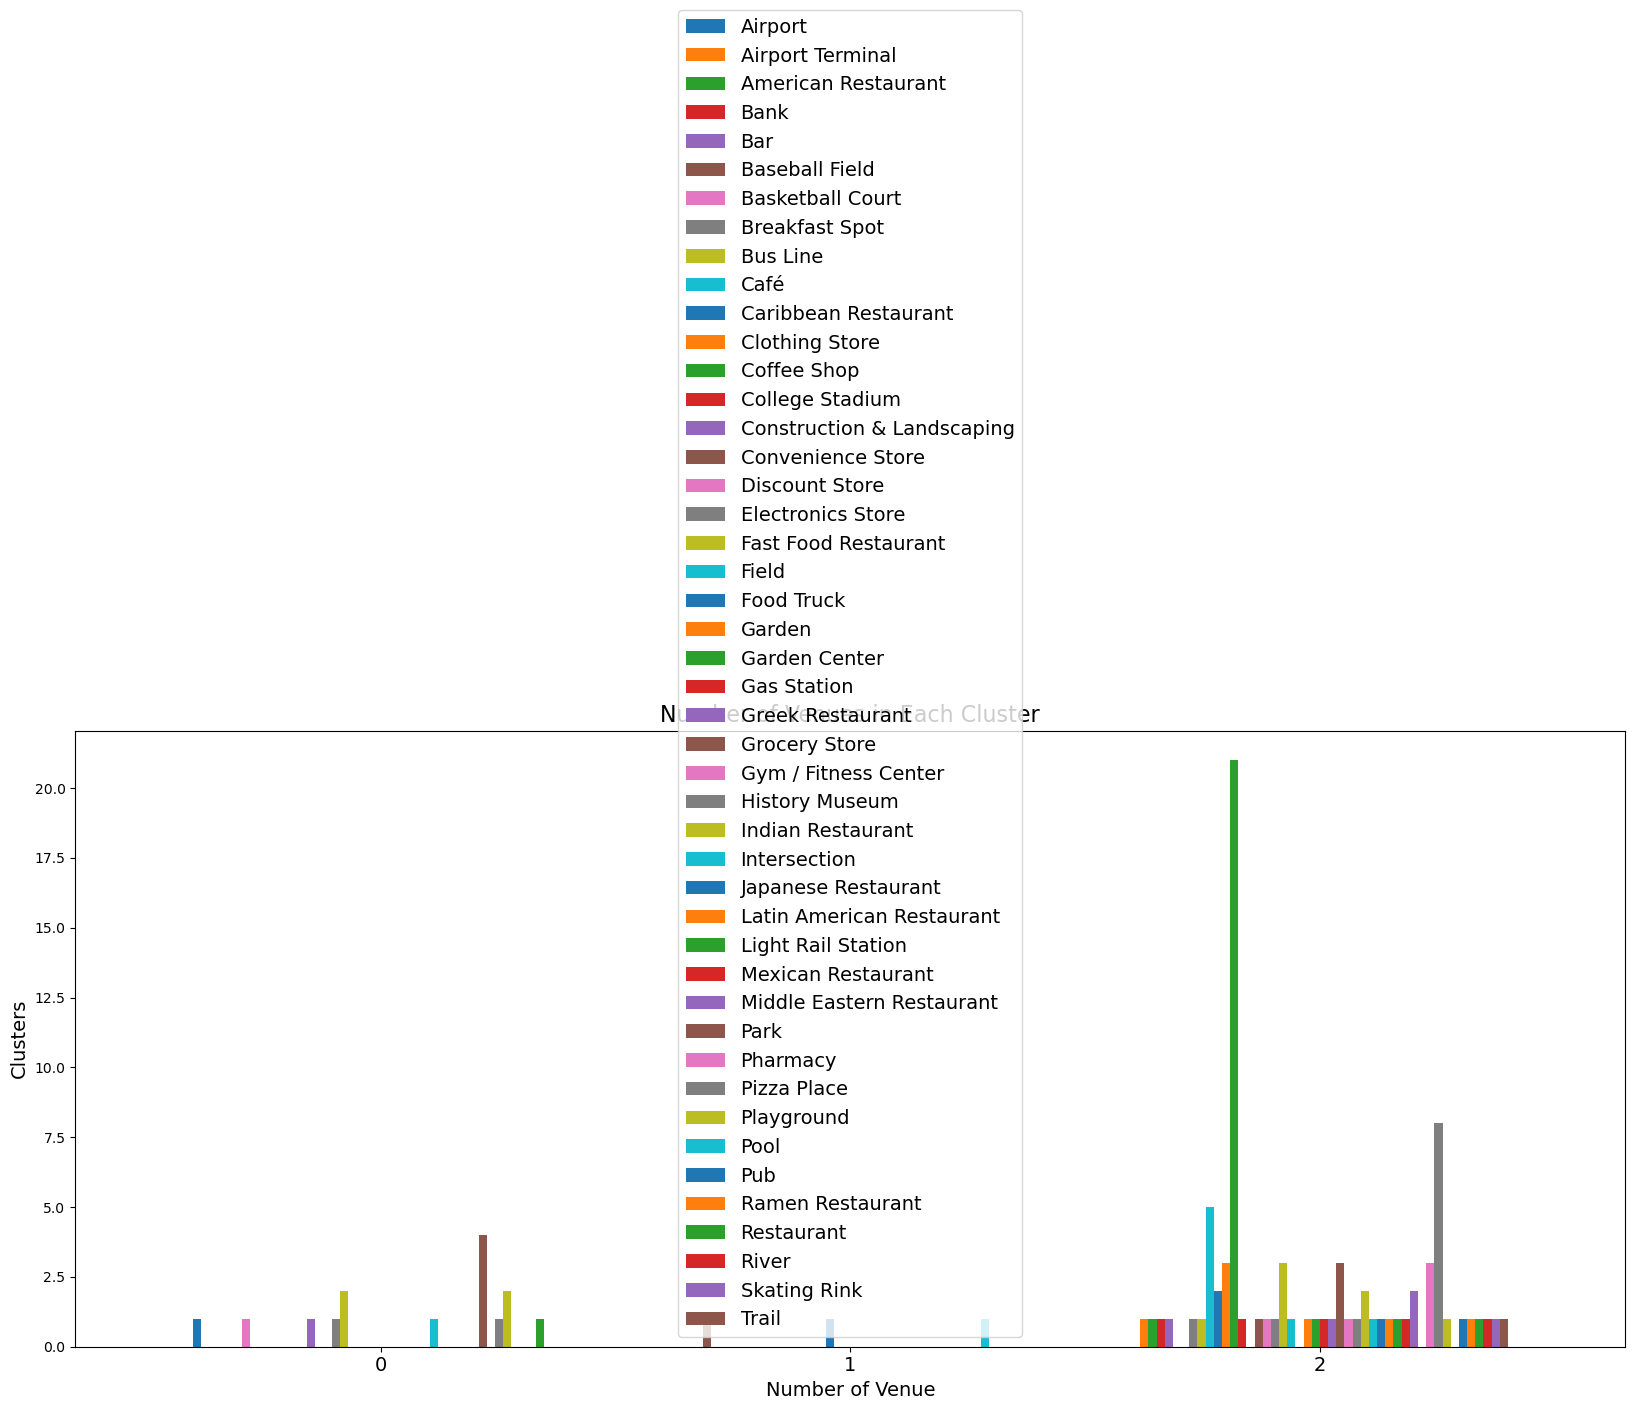

In [68]:
#creating a bar chart of "Number of Venues in Each Cluster"
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Number of Venue', fontsize=14)
plt.ylabel('Clusters', fontsize=14)



When we examine above graph we can label each cluster as follows:

Cluster 0 : "Baseball Field"
Cluster 1 : "Coffee Shop"
Cluster 2 : "Park"
We can now assign those new labels to existing label of clusters:

#### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [69]:
Cluster_labels = {'Clusters': [0,1,2], 'Labels': ["Baseball Field","Coffee Shop","Park"]}
Cluster_labels = pd.DataFrame(data=Cluster_labels)
Cluster_labels

,Clusters,Labels
0,0,Baseball Field
1,1,Coffee Shop
2,2,Park


In [70]:
final_result= pd.merge(toronto_merged, 
                    Cluster_labels[['Clusters', 'Labels']],
                    left_on = 'Cluster Labels',
                    right_on = 'Clusters',
                    how = 'left')

In [71]:
final_result = final_result.drop(['Clusters'], axis=1)
final_result.head(3)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Labels
0,M1S,Scarborough,Agincourt,43.794200,-79.262029,Latin American Restaurant,Lounge,Breakfast Spot,Skating Rink,Clothing Store,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,2,Park
1,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484,Pizza Place,Sandwich Place,Gym,Playground,Pool,Coffee Shop,Pub,Yoga Studio,Mobile Phone Shop,Moroccan Restaurant,2,Park
2,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,Bank,Coffee Shop,Restaurant,Ice Cream Shop,Sushi Restaurant,Fried Chicken Joint,Bridal Shop,Gas Station,Sandwich Place,Diner,2,Park


#### Finally, let's visualize the resulting clusters

In [72]:
toronto_merged['Cluster Labels']=toronto_merged['Cluster Labels'].fillna(0).astype('int') 

In [73]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,label in zip(final_result['Latitude'], final_result['Longitude'], final_result['Neighborhood'], final_result['Cluster Labels'], final_result['Labels'] ):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster)+ "-"+ str(label) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

### Cluster 1

In [74]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
21,York,Park,Women's Store,Pool,Middle Eastern Restaurant,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,0
40,North York,Airport,Park,Yoga Studio,Middle Eastern Restaurant,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,0
10,North York,Playground,Park,Bakery,Italian Restaurant,Japanese Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,0
77,Etobicoke,Pizza Place,Park,Bus Line,Sandwich Place,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,0
61,Central Toronto,Construction & Landscaping,Swim School,Park,Bus Line,Yoga Studio,Miscellaneous Shop,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,0
6,Scarborough,Fast Food Restaurant,Yoga Studio,Middle Eastern Restaurant,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Mexican Restaurant,0
85,Scarborough,Intersection,Playground,Park,Miscellaneous Shop,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,0
83,Central Toronto,Restaurant,Trail,Park,Summer Camp,Yoga Studio,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,0
49,North York,Basketball Court,Construction & Landscaping,Bakery,Park,Yoga Studio,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,0
0,North York,Fast Food Restaurant,Park,Food & Drink Shop,Yoga Studio,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,0


### Cluster 2

In [75]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
53,North York,Food Truck,Baseball Field,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Yoga Studio,Motel,1
57,North York,Baseball Field,Yoga Studio,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Middle Eastern Restaurant,Movie Theater,1
101,Etobicoke,Pool,Baseball Field,Yoga Studio,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Middle Eastern Restaurant,1


### Cluster 3

In [76]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
78,Scarborough,Latin American Restaurant,Lounge,Breakfast Spot,Skating Rink,Clothing Store,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,2
93,Etobicoke,Pizza Place,Sandwich Place,Gym,Playground,Pool,Coffee Shop,Pub,Yoga Studio,Mobile Phone Shop,Moroccan Restaurant,2
28,North York,Bank,Coffee Shop,Restaurant,Ice Cream Shop,Sushi Restaurant,Fried Chicken Joint,Bridal Shop,Gas Station,Sandwich Place,Diner,2
39,North York,Japanese Restaurant,Café,Chinese Restaurant,Bank,Yoga Studio,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,2
55,North York,Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Comfort Food Restaurant,Indian Restaurant,Pizza Place,Pub,Café,Butcher,2
20,Downtown Toronto,Coffee Shop,Cocktail Bar,Bakery,Seafood Restaurant,Restaurant,Beer Bar,Farmers Market,Pharmacy,Cheese Shop,Café,2
58,Scarborough,College Stadium,Café,General Entertainment,Skating Rink,Yoga Studio,Mobile Phone Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,2
43,West Toronto,Café,Breakfast Spot,Bakery,Nightclub,Coffee Shop,Intersection,Bar,Stadium,Restaurant,Italian Restaurant,2
87,Downtown Toronto,Airport Terminal,Airport Service,Harbor / Marina,Rental Car Location,Coffee Shop,Sculpture Garden,Boat or Ferry,Bar,Boutique,Plane,2
26,Scarborough,Gas Station,Bank,Caribbean Restaurant,Hakka Restaurant,Thai Restaurant,Athletics & Sports,Bakery,Fried Chicken Joint,Molecular Gastronomy Restaurant,Motel,2


## Discussion

### To start a new restaurant, we have to consider many things. Here we have taken a sample data for just a pair of location coordinates of the city and has just done a sample analysis with some assumptions. 
### While setting a restaurant based on particular cuisine, we have to consider the population data those who are interested in that particular cuisine in that particular location. As I have not considered census data, I assumed that the neighborhoods having Indian restaurants will be the locations where people are interested in that particular cuisine, so I have done my final analysis on the 13 neighborhoods having Indian Restaurants and concluded that 3 locations: 
## 'Davisville',  'Bedford Park, Lawrence Manor East',  'St. James Town, Cabbagetown'	 
### as the best places to start a new one.
### I have clustered the information on the Toronto map. I used the Kmeans algorithm as part of this clustering study.
For more detailed and accurate guidance, the data set can be expanded and different approaches can be tried in clustering and classification studies.

## Conclusion

### I have found out the best neighborhoods to start an Indian restaurant. I concluded the analysis by visualizing the data and clustering information on the Toronto map. 
### This kind of analysis will be helpful to investors,immigrants, tourists and many more.  